In [1]:
print('hi')

hi


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install albumentations==0.4.3

     |████████████████████████████████| 3.2MB 2.8MB/s 
     |████████████████████████████████| 634kB 33.1MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.3-cp36-none-any.whl size=60764 sha256=07b9f22b9fae6b6ec5f8c9c6a6bdf1bd7631101f92e4e8c6be0cb8d7712f358c
  Stored in directory: /root/.cache/pip/wheels/20/16/8e/d3bec34bf30adff30929226f0b83cc8c005b5af131f51db9d0
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=5bc94fe2be3b0f4d12d21ac1e7670a4b17062113306c7653252d04eddeb89b35
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [0]:
from __future__ import print_function, division, absolute_import
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch.nn.functional as F
import os
import cv2

# Any results you write to the current directory are saved as output.
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from tqdm import tqdm_notebook as tqdm
import math
import torch.utils.model_zoo as model_zoo

from PIL import Image, ImageOps, ImageEnhance
from albumentations.core.transforms_interface import ImageOnlyTransform

from albumentations import (
    Compose,Cutout
)
import matplotlib.pyplot as plt

def visualize(original_image,aug_image):
    fontsize = 18
    f, ax = plt.subplots(1, 2, figsize=(8, 8))
    ax[0].imshow(original_image, cmap='gray')
    ax[0].set_title('Original image', fontsize=fontsize)
    ax[1].imshow(aug_image,cmap='gray')
    ax[1].set_title('Augmented image', fontsize=fontsize)
my_size = 128

In [0]:
train_aug = Compose([ 
    Cutout(num_holes=1, max_h_size=60, max_w_size=90, fill_value=0, always_apply=False, p=1) ] )

In [0]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

import re
import math
import collections
from functools import partial
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import model_zoo

########################################################################
############### HELPERS FUNCTIONS FOR MODEL ARCHITECTURE ###############
########################################################################


# Parameters for the entire model (stem, all blocks, and head)
GlobalParams = collections.namedtuple('GlobalParams', [
    'batch_norm_momentum', 'batch_norm_epsilon', 'dropout_rate',
    'num_classes', 'width_coefficient', 'depth_coefficient',
    'depth_divisor', 'min_depth', 'drop_connect_rate', 'image_size'])

# Parameters for an individual model block
BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'id_skip', 'stride', 'se_ratio'])

# Change namedtuple defaults
GlobalParams.__new__.__defaults__ = (None,) * len(GlobalParams._fields)
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)


class SwishImplementation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class MemoryEfficientSwish(nn.Module):
    def forward(self, x):
        return SwishImplementation.apply(x)

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


def round_filters(filters, global_params):
    """ Calculate and round number of filters based on depth multiplier. """
    multiplier = global_params.width_coefficient
    if not multiplier:
        return filters
    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    filters *= multiplier
    min_depth = min_depth or divisor
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    if new_filters < 0.9 * filters:  # prevent rounding by more than 10%
        new_filters += divisor
    return int(new_filters)


def round_repeats(repeats, global_params):
    """ Round number of filters based on depth multiplier. """
    multiplier = global_params.depth_coefficient
    if not multiplier:
        return repeats
    return int(math.ceil(multiplier * repeats))


def drop_connect(inputs, p, training):
    """ Drop connect. """
    if not training: return inputs
    batch_size = inputs.shape[0]
    keep_prob = 1 - p
    random_tensor = keep_prob
    random_tensor += torch.rand([batch_size, 1, 1, 1], dtype=inputs.dtype, device=inputs.device)
    binary_tensor = torch.floor(random_tensor)
    output = inputs / keep_prob * binary_tensor
    return output


def get_same_padding_conv2d(image_size=None):
    """ Chooses static padding if you have specified an image size, and dynamic padding otherwise.
        Static padding is necessary for ONNX exporting of models. """
    if image_size is None:
        return Conv2dDynamicSamePadding
    else:
        return partial(Conv2dStaticSamePadding, image_size=image_size)


class Conv2dDynamicSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a dynamic image size """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2])
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


class Conv2dStaticSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a fixed image size"""

    def __init__(self, in_channels, out_channels, kernel_size, image_size=None, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

        # Calculate padding based on image size and save it
        assert image_size is not None
        ih, iw = image_size if type(image_size) == list else [image_size, image_size]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            self.static_padding = nn.ZeroPad2d((pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2))
        else:
            self.static_padding = Identity()

    def forward(self, x):
        x = self.static_padding(x)
        x = F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        return x


class Identity(nn.Module):
    def __init__(self, ):
        super(Identity, self).__init__()

    def forward(self, input):
        return input


########################################################################
############## HELPERS FUNCTIONS FOR LOADING MODEL PARAMS ##############
########################################################################


def efficientnet_params(model_name):
    """ Map EfficientNet model name to parameter coefficients. """
    params_dict = {
        # Coefficients:   width,depth,res,dropout
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),
    }
    return params_dict[model_name]


class BlockDecoder(object):
    """ Block Decoder for readability, straight from the official TensorFlow repository """

    @staticmethod
    def _decode_block_string(block_string):
        """ Gets a block through a string notation of arguments. """
        assert isinstance(block_string, str)

        ops = block_string.split('_')
        options = {}
        for op in ops:
            splits = re.split(r'(\d.*)', op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value

        # Check stride
        assert (('s' in options and len(options['s']) == 1) or
                (len(options['s']) == 2 and options['s'][0] == options['s'][1]))

        return BlockArgs(
            kernel_size=int(options['k']),
            num_repeat=int(options['r']),
            input_filters=int(options['i']),
            output_filters=int(options['o']),
            expand_ratio=int(options['e']),
            id_skip=('noskip' not in block_string),
            se_ratio=float(options['se']) if 'se' in options else None,
            stride=[int(options['s'][0])])

    @staticmethod
    def _encode_block_string(block):
        """Encodes a block to a string."""
        args = [
            'r%d' % block.num_repeat,
            'k%d' % block.kernel_size,
            's%d%d' % (block.strides[0], block.strides[1]),
            'e%s' % block.expand_ratio,
            'i%d' % block.input_filters,
            'o%d' % block.output_filters
        ]
        if 0 < block.se_ratio <= 1:
            args.append('se%s' % block.se_ratio)
        if block.id_skip is False:
            args.append('noskip')
        return '_'.join(args)

    @staticmethod
    def decode(string_list):
        """
        Decodes a list of string notations to specify blocks inside the network.
        :param string_list: a list of strings, each string is a notation of block
        :return: a list of BlockArgs namedtuples of block args
        """
        assert isinstance(string_list, list)
        blocks_args = []
        for block_string in string_list:
            blocks_args.append(BlockDecoder._decode_block_string(block_string))
        return blocks_args

    @staticmethod
    def encode(blocks_args):
        """
        Encodes a list of BlockArgs to a list of strings.
        :param blocks_args: a list of BlockArgs namedtuples of block args
        :return: a list of strings, each string is a notation of block
        """
        block_strings = []
        for block in blocks_args:
            block_strings.append(BlockDecoder._encode_block_string(block))
        return block_strings


def efficientnet(width_coefficient=None, depth_coefficient=None, dropout_rate=0.2,
                 drop_connect_rate=0.2, image_size=None, num_classes=1000):
    """ Creates a efficientnet model. """

    blocks_args = [
        'r1_k3_s11_e1_i32_o16_se0.25', 'r2_k3_s22_e6_i16_o24_se0.25',
        'r2_k5_s22_e6_i24_o40_se0.25', 'r3_k3_s22_e6_i40_o80_se0.25',
        'r3_k5_s11_e6_i80_o112_se0.25', 'r4_k5_s22_e6_i112_o192_se0.25',
        'r1_k3_s11_e6_i192_o320_se0.25',
    ]
    blocks_args = BlockDecoder.decode(blocks_args)

    global_params = GlobalParams(
        batch_norm_momentum=0.99,
        batch_norm_epsilon=1e-3,
        dropout_rate=dropout_rate,
        drop_connect_rate=drop_connect_rate,
        # data_format='channels_last',  # removed, this is always true in PyTorch
        num_classes=num_classes,
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        depth_divisor=8,
        min_depth=None,
        image_size=image_size,
    )

    return blocks_args, global_params


def get_model_params(model_name, override_params):
    """ Get the block args and global params for a given model """
    if model_name.startswith('efficientnet'):
        w, d, s, p = efficientnet_params(model_name)
        # note: all models have drop connect rate = 0.2
        blocks_args, global_params = efficientnet(
            width_coefficient=w, depth_coefficient=d, dropout_rate=p, image_size=s)
    else:
        raise NotImplementedError('model name is not pre-defined: %s' % model_name)
    if override_params:
        # ValueError will be raised here if override_params has fields not included in global_params.
        global_params = global_params._replace(**override_params)
    return blocks_args, global_params


url_map = {
    'efficientnet-b0': '/content/drive/My Drive/efficientnet-pytorch/efficientnet-b0-08094119.pth',
    'efficientnet-b1': '/content/drive/My Drive/efficientnet-pytorch/efficientnet-b1-dbc7070a.pth',
    'efficientnet-b2': '/content/drive/My Drive/efficientnet-pytorch/efficientnet-b2-27687264.pth',
    'efficientnet-b3': '/content/drive/My Drive/efficientnet-pytorch/efficientnet-b3-c8376fa2.pth',
    'efficientnet-b4': '/content/drive/My Drive/efficientnet-pytorch/efficientnet-b4-e116e8b3.pth',
    'efficientnet-b5': '/content/drive/My Drive/efficientnet-pytorch/efficientnet-b5-586e6cc6.pth',
    'efficientnet-b6': '/content/drive/My Drive/efficientnet-pytorch/efficientnet-b6-c76e70fd.pth',
    'efficientnet-b7': '/content/drive/My Drive/efficientnet-pytorch/efficientnet-b7-dcc49843.pth',
}

## This below function is modified to use the pretrained weight for single channel . Its nothing but summing the weight across one axis .
def load_pretrained_weights(model, model_name, load_fc=True,ch=1):
    """ Loads pretrained weights, and downloads if loading for the first time. """
    state_dict = torch.load('/content/drive/My Drive/efficientnet-pytorch/efficientnet-b5-586e6cc6.pth')
    if load_fc:
        if ch == 1:
            conv1_weight = state_dict['_conv_stem.weight']
            state_dict['_conv_stem.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        model.load_state_dict(state_dict)
        
    else:
        state_dict.pop('_fc.weight')
        state_dict.pop('_fc.bias')
        if ch == 1:
            conv1_weight = state_dict['_conv_stem.weight']
            state_dict['_conv_stem.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        res = model.load_state_dict(state_dict, strict=False)
        print(res.missing_keys)
        assert set(res.missing_keys) == set(['_fc.weight', '_fc.bias','fc1.weight', 'fc1.bias','fc2.weight', 'fc2.bias','fc3.weight', 'fc3.bias']), 'issue loading pretrained weights'
    print('Loaded pretrained weights for {}'.format(model_name))


In [0]:
import torch
from torch import nn
from torch.nn import functional as F


class MBConvBlock(nn.Module):
    """
    Mobile Inverted Residual Bottleneck Block
    Args:
        block_args (namedtuple): BlockArgs, see above
        global_params (namedtuple): GlobalParam, see above
    Attributes:
        has_se (bool): Whether the block contains a Squeeze and Excitation layer.
    """

    def __init__(self, block_args, global_params):
        super().__init__()
        self._block_args = block_args
        self._bn_mom = 1 - global_params.batch_norm_momentum
        self._bn_eps = global_params.batch_norm_epsilon
        self.has_se = (self._block_args.se_ratio is not None) and (0 < self._block_args.se_ratio <= 1)
        self.id_skip = block_args.id_skip  # skip connection and drop connect

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        # Expansion phase
        inp = self._block_args.input_filters  # number of input channels
        oup = self._block_args.input_filters * self._block_args.expand_ratio  # number of output channels
        if self._block_args.expand_ratio != 1:
            self._expand_conv = Conv2d(in_channels=inp, out_channels=oup, kernel_size=1, bias=False)
            self._bn0 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Depthwise convolution phase
        k = self._block_args.kernel_size
        s = self._block_args.stride
        self._depthwise_conv = Conv2d(
            in_channels=oup, out_channels=oup, groups=oup,  # groups makes it depthwise
            kernel_size=k, stride=s, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Squeeze and Excitation layer, if desired
        if self.has_se:
            num_squeezed_channels = max(1, int(self._block_args.input_filters * self._block_args.se_ratio))
            self._se_reduce = Conv2d(in_channels=oup, out_channels=num_squeezed_channels, kernel_size=1)
            self._se_expand = Conv2d(in_channels=num_squeezed_channels, out_channels=oup, kernel_size=1)

        # Output phase
        final_oup = self._block_args.output_filters
        self._project_conv = Conv2d(in_channels=oup, out_channels=final_oup, kernel_size=1, bias=False)
        self._bn2 = nn.BatchNorm2d(num_features=final_oup, momentum=self._bn_mom, eps=self._bn_eps)
        self._swish = MemoryEfficientSwish()

    def forward(self, inputs, drop_connect_rate=None):
        """
        :param inputs: input tensor
        :param drop_connect_rate: drop connect rate (float, between 0 and 1)
        :return: output of block
        """

        # Expansion and Depthwise Convolution
        x = inputs
        if self._block_args.expand_ratio != 1:
            x = self._swish(self._bn0(self._expand_conv(inputs)))
        x = self._swish(self._bn1(self._depthwise_conv(x)))

        # Squeeze and Excitation
        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_expand(self._swish(self._se_reduce(x_squeezed)))
            x = torch.sigmoid(x_squeezed) * x

        x = self._bn2(self._project_conv(x))

        # Skip connection and drop connect
        input_filters, output_filters = self._block_args.input_filters, self._block_args.output_filters
        if self.id_skip and self._block_args.stride == 1 and input_filters == output_filters:
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs  # skip connection
        return x

    def set_swish(self, memory_efficient=True):
        """Sets swish function as memory efficient (for training) or standard (for export)"""
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()


class EfficientNet(nn.Module):
    """
    An EfficientNet model. Most easily loaded with the .from_name or .from_pretrained methods
    Args:
        blocks_args (list): A list of BlockArgs to construct blocks
        global_params (namedtuple): A set of GlobalParams shared between blocks
    Example:
        model = EfficientNet.from_pretrained('efficientnet-b0')
    """

    def __init__(self, blocks_args=None, global_params=None):
        super().__init__()
        assert isinstance(blocks_args, list), 'blocks_args should be a list'
        assert len(blocks_args) > 0, 'block args must be greater than 0'
        self._global_params = global_params
        self._blocks_args = blocks_args

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        # Batch norm parameters
        bn_mom = 1 - self._global_params.batch_norm_momentum
        bn_eps = self._global_params.batch_norm_epsilon

        # Stem
        in_channels = 1  # rgb
        out_channels = round_filters(32, self._global_params)  # number of output channels
        self._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        self._bn0 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Build blocks
        self._blocks = nn.ModuleList([])
        for block_args in self._blocks_args:

            # Update block input and output filters based on depth multiplier.
            block_args = block_args._replace(
                input_filters=round_filters(block_args.input_filters, self._global_params),
                output_filters=round_filters(block_args.output_filters, self._global_params),
                num_repeat=round_repeats(block_args.num_repeat, self._global_params)
            )

            # The first block needs to take care of stride and filter size increase.
            self._blocks.append(MBConvBlock(block_args, self._global_params))
            if block_args.num_repeat > 1:
                block_args = block_args._replace(input_filters=block_args.output_filters, stride=1)
            for _ in range(block_args.num_repeat - 1):
                self._blocks.append(MBConvBlock(block_args, self._global_params))

        # Head
        f = 1282
        in_channels = block_args.output_filters  # output of final block
        out_channels = round_filters(f, self._global_params)
        self._conv_head = Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Final linear layer
        self._avg_pooling = nn.AdaptiveAvgPool2d(1)
        self._dropout = nn.Dropout(self._global_params.dropout_rate)
        self._fc = nn.Linear(out_channels, self._global_params.num_classes)
        # vowel_diacritic
        self.fc1 = nn.Linear(out_channels,11)
        # grapheme_root
        self.fc2 = nn.Linear(out_channels,168)
        # consonant_diacritic
        self.fc3 = nn.Linear(out_channels,7)
        self._swish = MemoryEfficientSwish()

    def set_swish(self, memory_efficient=True):
        """Sets swish function as memory efficient (for training) or standard (for export)"""
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()
        for block in self._blocks:
            block.set_swish(memory_efficient)


    def extract_features(self, inputs):
        """ Returns output of the final convolution layer """

        # Stem
        x = self._swish(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            x = block(x, drop_connect_rate=drop_connect_rate)

        # Head
        x = self._swish(self._bn1(self._conv_head(x)))

        return x

    def forward(self, inputs):
        """ Calls extract_features to extract features, applies final linear layer, and returns logits. """
        bs = inputs.size(0)
        # Convolution layers
        x = self.extract_features(inputs)

        # Pooling and final linear layer
        x = self._avg_pooling(x)
        x = x.view(bs, -1)
        x = self._dropout(x)
       # x = self._fc(x)
        x1 = self.fc1(x)
        x2= self.fc2(x)
        x3 = self.fc3(x)
        return x1,x2,x3

    @classmethod
    def from_name(cls, model_name, override_params=None):
        cls._check_model_name_is_valid(model_name)
        blocks_args, global_params = get_model_params(model_name, override_params)
        return cls(blocks_args, global_params)

    @classmethod
    def from_pretrained(cls, model_name, num_classes=1000, in_channels = 1):
        model = cls.from_name(model_name, override_params={'num_classes': num_classes})
        load_pretrained_weights(model, model_name, load_fc=False)
        if in_channels != 3:
            Conv2d = get_same_padding_conv2d(image_size = model._global_params.image_size)
            out_channels = round_filters(32, model._global_params)
            model._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        return model
    
    @classmethod
    def from_pretrained(cls, model_name, num_classes=1000):
        model = cls.from_name(model_name, override_params={'num_classes': num_classes})
        load_pretrained_weights(model, model_name, load_fc=False)

        return model

    @classmethod
    def get_image_size(cls, model_name):
        cls._check_model_name_is_valid(model_name)
        _, _, res, _ = efficientnet_params(model_name)
        return res

    @classmethod
    def _check_model_name_is_valid(cls, model_name, also_need_pretrained_weights=False):
        """ Validates model name. None that pretrained weights are only available for
        the first four models (efficientnet-b{i} for i in 0,1,2,3) at the moment. """
        num_models = 4 if also_need_pretrained_weights else 8
        valid_models = ['efficientnet-b'+str(i) for i in range(num_models)]
        if model_name not in valid_models:
            raise ValueError('model_name should be one of: ' + ', '.join(valid_models))

In [8]:
train = pd.read_csv('/content/drive/My Drive/bengaliaicv19feather/train.csv')
data0 = pd.read_feather('/content/drive/My Drive/black_128/train_data_0_ors.feather')
data1 = pd.read_feather('/content/drive/My Drive/black_128/train_data_1_ors.feather')
data2 = pd.read_feather('/content/drive/My Drive/black_128/train_data_2_ors.feather')  
data3 = pd.read_feather('/content/drive/My Drive/black_128/train_data_3_ors.feather')

'''data0 = pd.read_feather('/content/drive/My Drive/black64/train_data_0_64.feather')
data1 = pd.read_feather('/content/drive/My Drive/black64/train_data_1_64.feather')
data2 = pd.read_feather('/content/drive/My Drive/black64/train_data_2_64.feather')  
data3 = pd.read_feather('/content/drive/My Drive/black64/train_data_3_64.feather')'''

"data0 = pd.read_feather('/content/drive/My Drive/black64/train_data_0_64.feather')\ndata1 = pd.read_feather('/content/drive/My Drive/black64/train_data_1_64.feather')\ndata2 = pd.read_feather('/content/drive/My Drive/black64/train_data_2_64.feather')  \ndata3 = pd.read_feather('/content/drive/My Drive/black64/train_data_3_64.feather')"

In [0]:
data_full = pd.concat([data0,data1,data2,data3],ignore_index=True)
del data0,data1,data2,data3

In [0]:
class GraphemeDataset(Dataset):
    def __init__(self,df,label,_type='train',transform =False,aug = train_aug):
        self.df = df
        self.label = label
        self.aug = aug
        self.transform = transform
        self.data = df.iloc[:, 1:].values
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        label1 = self.label.vowel_diacritic.values[idx]
        label2 = self.label.grapheme_root.values[idx]
        label3 = self.label.consonant_diacritic.values[idx]
        image = self.data[idx, :].reshape(my_size,my_size).astype(np.float)
        if self.transform: 
            augment = self.aug(image = image)
            image = augment['image']
        return image,label1,label2,label3

In [0]:
from sklearn.model_selection import train_test_split
train_df , valid_df = train_test_split(train,test_size=0.20, random_state=42,shuffle=True) ## Split Labels
data_train_df, data_valid_df = train_test_split(data_full,test_size=0.20, random_state=42,shuffle =True) ## split data

In [12]:
import gc
gc.collect()

0

In [13]:
train_dataset = GraphemeDataset(data_train_df ,train_df,transform = True) 
valid_dataset = GraphemeDataset(data_valid_df ,valid_df,transform = False) 
torch.cuda.empty_cache()
gc.collect()

0

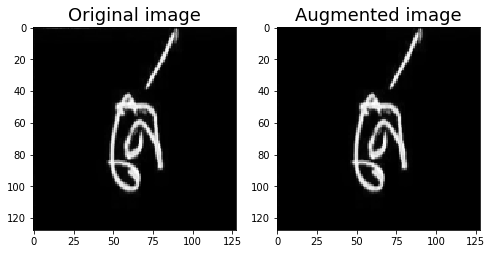

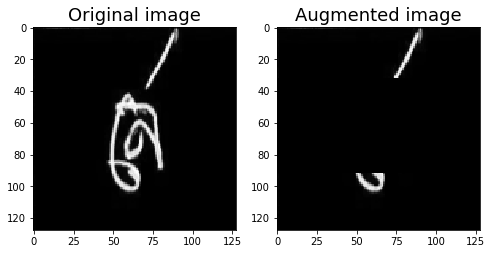

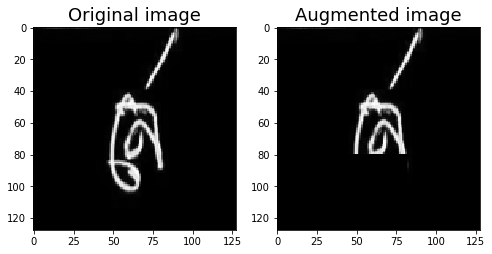

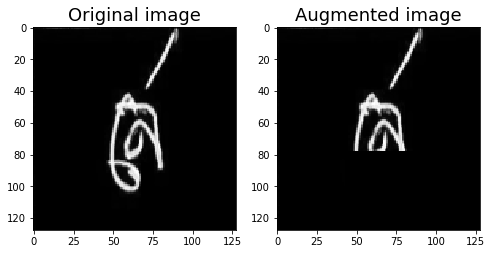

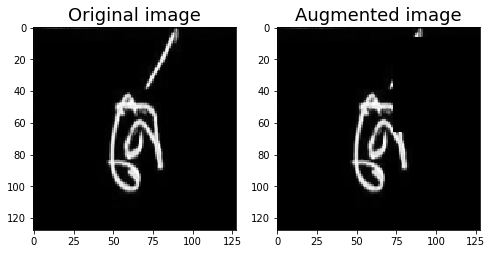

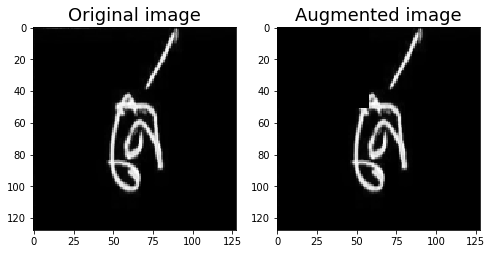

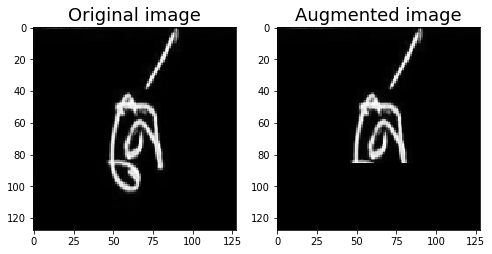

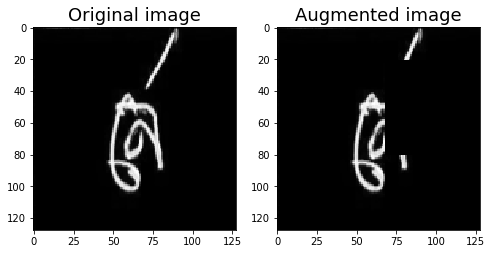

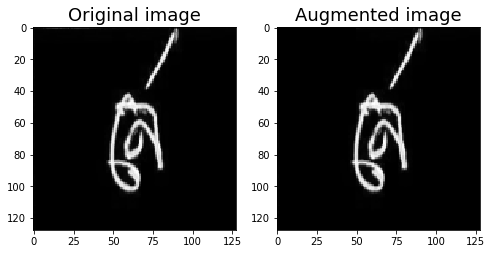

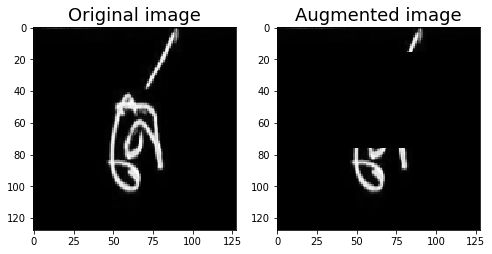

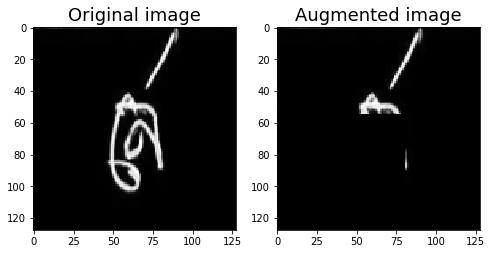

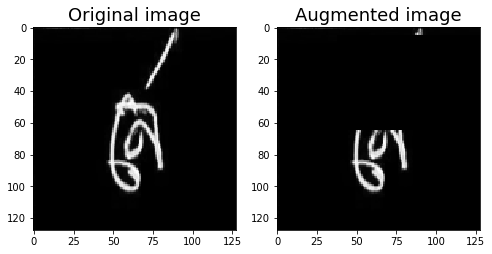

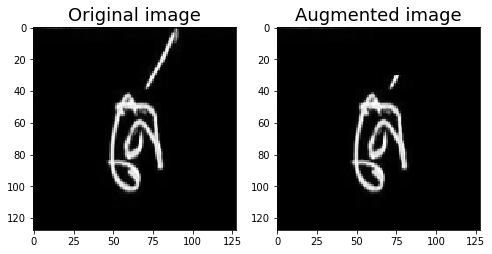

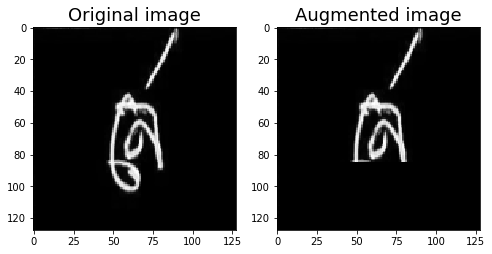

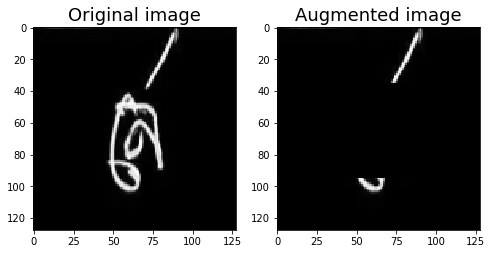

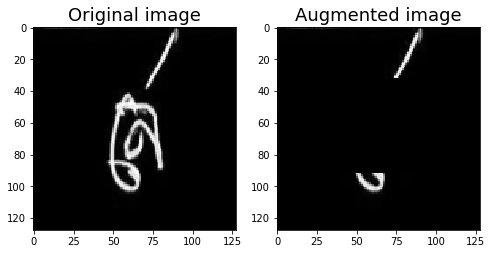

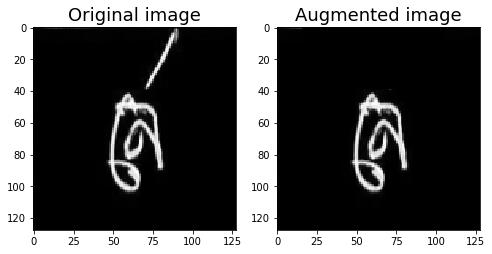

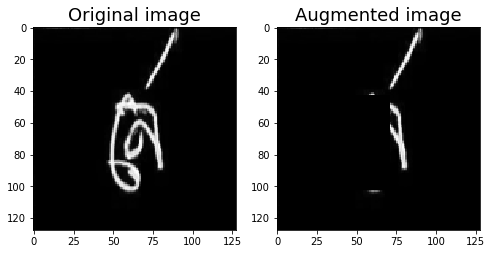

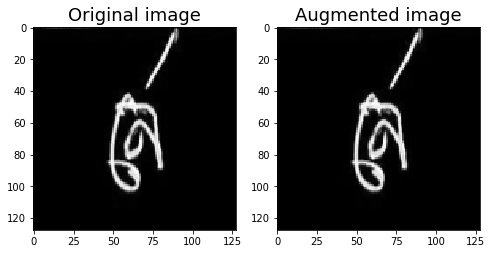

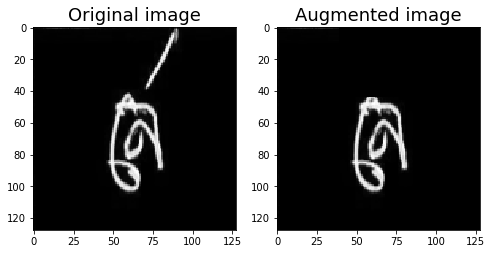

In [14]:
orig_image = data_train_df.iloc[23, 1:].values.reshape(128,128).astype(np.float)
aug_image = train_dataset[1][1]
for i in range (20):
    aug_image = train_dataset[23][0]
    visualize (orig_image,aug_image)

In [15]:
del train_df,valid_df,data_train_df,data_valid_df 
torch.cuda.empty_cache()
gc.collect()

93306

In [0]:
batch_size = 120
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, num_workers = 12,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=batch_size,num_workers = 12, shuffle=True)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = EfficientNet.from_pretrained('efficientnet-b5').to(device)
#model.swish = Mish()
model.load_state_dict(torch.load('/content/drive/My Drive/128/one_only_cutoutb5.pth'))

cuda:0
['_fc.weight', '_fc.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias']
Loaded pretrained weights for efficientnet-b5


<All keys matched successfully>

In [0]:
optimizer = torch.optim.AdamW(model.parameters(), lr= 0.0015)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                            mode="min", 
                                                            patience=2, 
                                                            factor=0.3,verbose=True)
batch_size=batch_size
criterion = nn.CrossEntropyLoss()

In [0]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(y[:, 0], pred_labels[0],  average='macro')
    recall_vowel = sklearn.metrics.recall_score(y[:, 1], pred_labels[1],  average='macro')
    recall_consonant = sklearn.metrics.recall_score(y[:, 2], pred_labels[2],  average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score

def macro_recall_multi(pred_graphemes, true_graphemes,pred_vowels,true_vowels,pred_consonants,true_consonants, n_grapheme=168, n_vowel=11, n_consonant=7):
    #pred_y = torch.split(pred_y, [n_grapheme], dim=1)
    pred_label_graphemes = torch.argmax(pred_graphemes, dim=1).cpu().numpy()

    true_label_graphemes = true_graphemes.cpu().numpy()
    
    pred_label_vowels = torch.argmax(pred_vowels, dim=1).cpu().numpy()

    true_label_vowels = true_vowels.cpu().numpy()
    
    pred_label_consonants = torch.argmax(pred_consonants, dim=1).cpu().numpy()

    true_label_consonants = true_consonants.cpu().numpy()    
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(true_label_graphemes, pred_label_graphemes,  average='macro')
    recall_vowel = sklearn.metrics.recall_score(true_label_vowels, pred_label_vowels,  average='macro')
    recall_consonant = sklearn.metrics.recall_score(true_label_consonants, pred_label_consonants,  average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    #print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [0]:
def train(epoch):
  model.train()
  losses = []
  accs = []
  acc= 0.0
  total = 0.0
  running_loss = 0.0
  running_acc = 0.0
  running_recall = 0.0
  for idx, (inputs,labels1,labels2,labels3) in enumerate(train_loader):
      inputs = inputs.to(device)
      labels1 = labels1.to(device)
      labels2 = labels2.to(device)
      labels3 = labels3.to(device)
      total += len(inputs)
      optimizer.zero_grad()
      outputs1,outputs2,outputs3 = model(inputs.unsqueeze(1).float())
      loss1 = criterion(outputs1,labels1)
      loss2 = 2* criterion(outputs2,labels2)
      loss3 = criterion(outputs3,labels3)
      running_loss += loss1.item()+loss2.item()+loss3.item()
      running_recall+= macro_recall_multi(outputs2,labels2,outputs1,labels1,outputs3,labels3)
      running_acc += (outputs1.argmax(1)==labels1).float().mean()
      running_acc += (outputs2.argmax(1)==labels2).float().mean()
      running_acc += (outputs3.argmax(1)==labels3).float().mean()
      (loss1+loss2+loss3).backward()
      optimizer.step()
      optimizer.zero_grad()
      acc = running_acc/total
      #scheduler.step(running_loss)
  losses.append(running_loss/len(train_loader))
  accs.append(running_acc/(len(train_loader)*3))
  print('--'*60)
  print(' train epoch : {}\tacc : {:.2f}%'.format(epoch,running_acc/(len(train_loader)*3)))
  print('loss : {:.4f}'.format(running_loss/len(train_loader)))
  print('recall: {:.4f}'.format(running_recall/len(train_loader)))
  total_train_recall = running_recall/len(train_loader)
  torch.cuda.empty_cache()
  gc.collect()
  return  total_train_recall
def evaluate(epoch):
   model.eval()
   losses = []
   accs = []
   recalls = []
   acc= 0.0
   total = 0.0
   #print('epochs {}/{} '.format(epoch+1,epochs))
   running_loss = 0.0
   running_acc = 0.0
   running_recall = 0.0
   with torch.no_grad():
     for idx, (inputs,labels1,labels2,labels3) in enumerate(valid_loader):
        inputs = inputs.to(device)
        labels1 = labels1.to(device)
        labels2 = labels2.to(device)
        labels3 = labels3.to(device)
        total += len(inputs)
        outputs1,outputs2,outputs3 = model(inputs.unsqueeze(1).float())
        loss1 = criterion(outputs1,labels1)
        loss2 = 2*criterion(outputs2,labels2)
        loss3 = criterion(outputs3,labels3)
        running_loss += loss1.item()+loss2.item()+loss3.item()
        running_recall+= macro_recall_multi(outputs2,labels2,outputs1,labels1,outputs3,labels3)
        running_acc += (outputs1.argmax(1)==labels1).float().mean()
        running_acc += (outputs2.argmax(1)==labels2).float().mean()
        running_acc += (outputs3.argmax(1)==labels3).float().mean()
        acc = running_acc/total
        #scheduler.step()
   shed_rec = running_loss/len(valid_loader)
   scheduler.step(shed_rec)
   losses.append(running_loss/len(valid_loader))
   accs.append(running_acc/(len(valid_loader)*3))
   recalls.append(running_recall/len(valid_loader))
   total_recall = running_recall/len(valid_loader)
   print('val epoch: {} \tval acc : {:.2f}%'.format(epoch,running_acc/(len(valid_loader)*3)))
   print('loss : {:.4f}'.format(running_loss/len(valid_loader)))
   print('recall: {:.4f}'.format(running_recall/len(valid_loader)))
   return  total_recall

In [0]:
#hello
#8:03   started training
n_epochs = 100
best_valid_recall = 00.9913
for epoch in range(n_epochs): 
    torch.cuda.empty_cache()
    gc.collect()
    train_recall = train(epoch)
    valid_recall = evaluate(epoch)
    if valid_recall > best_valid_recall:
        print(f'Validation recall has increased from:  {best_valid_recall:.8f} to: {valid_recall:.8f}. Saving checkpoint')
        torch.save(model.state_dict(), '/content/drive/My Drive/128/Retraining_one_only_cutoutb5.pth') ## Saving model weights based on best validation accuracy.
        best_valid_recall = valid_recall

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


------------------------------------------------------------------------------------------------------------------------
 train epoch : 0	acc : 0.94%
loss : 0.9122
recall: 0.8993
val epoch: 0 	val acc : 0.99%
loss : 0.2299
recall: 0.9727
------------------------------------------------------------------------------------------------------------------------
 train epoch : 1	acc : 0.94%
loss : 0.9453
recall: 0.8954
val epoch: 1 	val acc : 0.99%
loss : 0.1829
recall: 0.9779
------------------------------------------------------------------------------------------------------------------------
 train epoch : 2	acc : 0.94%
loss : 0.9504
recall: 0.8944
val epoch: 2 	val acc : 0.99%
loss : 0.1949
recall: 0.9788
------------------------------------------------------------------------------------------------------------------------
 train epoch : 3	acc : 0.94%
loss : 0.9306
recall: 0.8973
val epoch: 3 	val acc : 0.99%
loss : 0.1896
recall: 0.9790
------------------------------------------------

In [0]:
#:) :) :) :)    